# Active Learning Pipeline

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.auto import tqdm

from scripts.utils import ScaleData, train_keys, target_keys

### Preparing Data

For now we will only look at a pipeline for the ITG flux. Starting with data that does give a QuaLiKiz result, run the ITG classifier and for data that is unstable use the QLKNN regressor to predict the flux.

In [2]:
train_data = pd.read_pickle("/home/tmadula/data/UKAEA/train_data_clipped.pkl").sample(1_000_000)
validation_data = pd.read_pickle("/home/tmadula/data/UKAEA/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]


0.26665124254879013


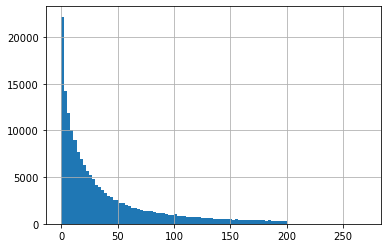

In [3]:
train_data[train_data["efiitg_gb"] != 0]["efiitg_gb"].hist(bins=100)
print(len(train_data[train_data["efiitg_gb"] != 0]) / len(train_data))

### Basic ITG Models for Prototyping

In [4]:
torch.set_default_dtype(torch.float32)

class ITG_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class ITG_Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

class ITGDataset(Dataset):
    def __init__(self, X, y, z = None):
        self.X = X
        self.y = y
        self.z = z

    # number of rows in the dataset
    def __len__(self):
        return len(self.y)

    # get a row at an index
    def __getitem__(self, idx):
        if self.z is not None:
            return[self.X[idx], self.y[idx], self.z[idx]]
        else:
            return [self.X[idx], self.y[idx]]

    # add method to add a new row to the dataset
    def add(self, x, y, z = None):
        self.X = np.append(self.X, x, axis = 0)
        self.y = np.append(self.y, y, axis = 0)
        
        if z is not None:
            self.z = np.append(self.z, z, axis = 0)


#### Pretrain Classifier
We will pretrain the classifier and then freeze the weights so that we only update the regressor during the active learning process.

In [5]:
keep_keys = train_keys + ["efiitg_gb"]

train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['itg'] = np.where(train_data['efiitg_gb'] != 0, 1, 0)
validation_data['itg'] = np.where(validation_data['efiitg_gb'] != 0, 1, 0)

assert len(train_data['itg'].unique()) == 2
assert len(validation_data['itg'].unique()) == 2

In [6]:
#x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
#x_val, y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()
x_train = train_data[train_keys].to_numpy()
y_train_class = train_data['itg'].to_numpy()
y_train_reg =  train_data['efiitg_gb'].to_numpy()

x_val = validation_data[train_keys].to_numpy()
y_val_class = validation_data['itg'].to_numpy()
y_val_reg =  validation_data['efiitg_gb'].to_numpy()

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform (x_val)

scaler_reg = StandardScaler()

y_train_reg = scaler_reg.fit_transform(y_train_reg.reshape(-1,1))
y_val_reg = scaler_reg.transform(y_val_reg.reshape(-1,1))

training = ITGDataset(x_train, y_train_class)
train_dataloader = DataLoader(training, batch_size=1024, shuffle=True)

validation = ITGDataset(x_val, y_val_class)
validation_dataloader = DataLoader(validation, batch_size=1024, shuffle=True)


In [7]:
classifier = ITG_Classifier()

learning_rate = 1e-3
batch_size = 2048
epochs = 10

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
def train_loop(train_loader, model, loss_fn, optimizer,epochs=20, val_loader=None):
    size_train = len(train_loader.dataset)
    num_batches_train = len(train_loader)
    
    size_val = len(val_loader.dataset)
    num_batches_val = len(val_loader)
    
    for epoch in range(epochs):
        
        for batch, (X, y) in enumerate(tqdm(train_loader, desc =f'Epoch {epoch}')):
            # Compute prediction and loss
            pred = model(X.float())
            loss = loss_fn(pred, y.unsqueeze(-1).float())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch == num_batches_train - 1:
                loss = loss.item()
                print(f"loss: {loss:>7f}")
        
        test_loss, correct = 0, 0
        print("\nValidating... \n")
        with torch.no_grad():
            for X, y in val_loader:
                pred = model(X.float())
                test_loss += loss_fn(pred, y.unsqueeze(-1).float()).item()
                # calculate test accuracy
                pred_class = torch.round(pred.squeeze())
                correct += torch.sum(pred_class == y.float()).item()

        
        test_loss /= num_batches_val
        correct /= size_val
        print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
train_loop(train_dataloader, classifier, loss_fn, optimizer, val_loader=validation_dataloader)

Epoch 0:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.160813

 Validating... 

Accuracy: 94.0%, Avg loss: 0.142653 



Epoch 1:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.132383

 Validating... 

Accuracy: 94.7%, Avg loss: 0.127245 



Epoch 2:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.129169

 Validating... 

Accuracy: 94.9%, Avg loss: 0.119894 



Epoch 3:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.108442

 Validating... 

Accuracy: 95.2%, Avg loss: 0.113517 



Epoch 4:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.118648

 Validating... 

Accuracy: 95.3%, Avg loss: 0.111733 



Epoch 5:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.102269

 Validating... 

Accuracy: 95.4%, Avg loss: 0.109309 



Epoch 6:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.092101

 Validating... 

Accuracy: 95.4%, Avg loss: 0.108381 



Epoch 7:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.107686

 Validating... 

Accuracy: 95.5%, Avg loss: 0.107263 



Epoch 8:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.108945

 Validating... 

Accuracy: 95.6%, Avg loss: 0.104524 



Epoch 9:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.094845

 Validating... 

Accuracy: 95.7%, Avg loss: 0.103619 



Epoch 10:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.092627

 Validating... 

Accuracy: 95.6%, Avg loss: 0.104594 



Epoch 11:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.090465

 Validating... 

Accuracy: 95.8%, Avg loss: 0.102311 



Epoch 12:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.091039

 Validating... 

Accuracy: 95.7%, Avg loss: 0.102684 



Epoch 13:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.096075

 Validating... 

Accuracy: 95.8%, Avg loss: 0.101694 



Epoch 14:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.098943

 Validating... 

Accuracy: 95.8%, Avg loss: 0.100650 



Epoch 15:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.106224

 Validating... 

Accuracy: 95.8%, Avg loss: 0.100081 



Epoch 16:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.105183

 Validating... 

Accuracy: 95.9%, Avg loss: 0.099769 



Epoch 17:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.101109

 Validating... 

Accuracy: 95.9%, Avg loss: 0.099847 



Epoch 18:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.069326

 Validating... 

Accuracy: 95.8%, Avg loss: 0.100930 



Epoch 19:   0%|          | 0/646 [00:00<?, ?it/s]

loss: 0.114648

 Validating... 

Accuracy: 95.9%, Avg loss: 0.099283 



In [10]:
# temporarily save model
torch.save(classifier.state_dict(), "classifier_model.pt")

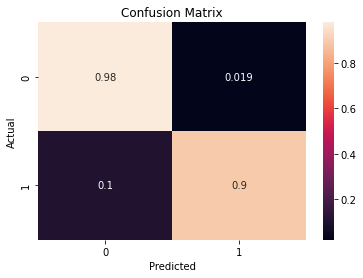

In [11]:
# get confusion matrix
y_pred = classifier(torch.tensor(x_val).float())
y_pred = torch.round(y_pred.squeeze())
y_pred = y_pred.detach().numpy()

con_mat = confusion_matrix(y_val_class, y_pred)
con_mat = con_mat / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Pretrain Regressor

Now we will pretrain the regressor on a very small subset of the data and use that as our base for the active learning process.

In [12]:
indices = np.random.choice(len(x_train), size=100_000, replace=False)

reg_train = ITGDataset(x_train[indices], y_train_class[indices], y_train_reg[indices])
reg_train_dataloader = DataLoader(reg_train, batch_size=1000, shuffle=True)

reg_val = ITGDataset(x_val, y_val_class, y_val_reg)
reg_val_dataloader = DataLoader(reg_val, batch_size=1024, shuffle=False)

In [13]:
def regression_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, z.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == num_batches - 1:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

def regression_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, z.float()).item()

    test_loss /= num_batches
    print(f"Test Error - avg loss: {test_loss:>8f} \n")

In [14]:
regressor = ITG_Regressor()

learning_rate = 1e-4
batch_size = 128
epochs = 25

MSE_loss = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=learning_rate, weight_decay=1e-4)

In [15]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    regression_train_loop(reg_train_dataloader, regressor, MSE_loss, optimizer)
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.832197
Test Error - avg loss: 0.796536 

Epoch 2
-------------------------------
loss: 0.636044
Test Error - avg loss: 0.638330 

Epoch 3
-------------------------------
loss: 0.532567
Test Error - avg loss: 0.500108 

Epoch 4
-------------------------------
loss: 0.475238
Test Error - avg loss: 0.400639 

Epoch 5
-------------------------------
loss: 0.311957
Test Error - avg loss: 0.351109 

Epoch 6
-------------------------------
loss: 0.325560
Test Error - avg loss: 0.321877 

Epoch 7
-------------------------------
loss: 0.349426
Test Error - avg loss: 0.302251 

Epoch 8
-------------------------------
loss: 0.292897
Test Error - avg loss: 0.287313 

Epoch 9
-------------------------------
loss: 0.228502
Test Error - avg loss: 0.274736 

Epoch 10
-------------------------------
loss: 0.294708
Test Error - avg loss: 0.264506 

Epoch 11
-------------------------------
loss: 0.269830
Test Error - avg loss: 0.256408 

Epoch 12
----------

In [16]:
# temporarily save model
torch.save(regressor.state_dict(), "regression_model.pt")

In [17]:
# load regression model
regressor = ITG_Regressor()
regressor.load_state_dict(torch.load("regression_model.pt"))

<All keys matched successfully>

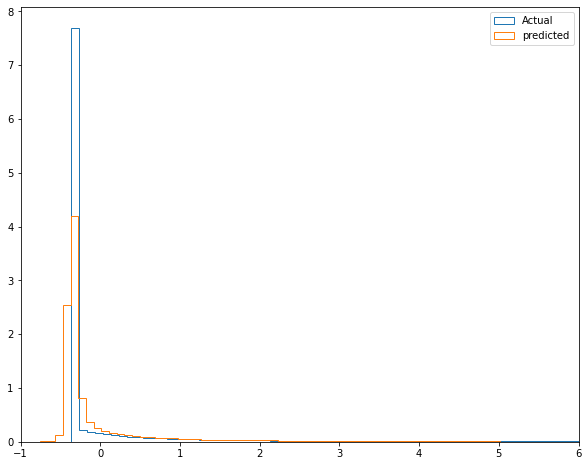

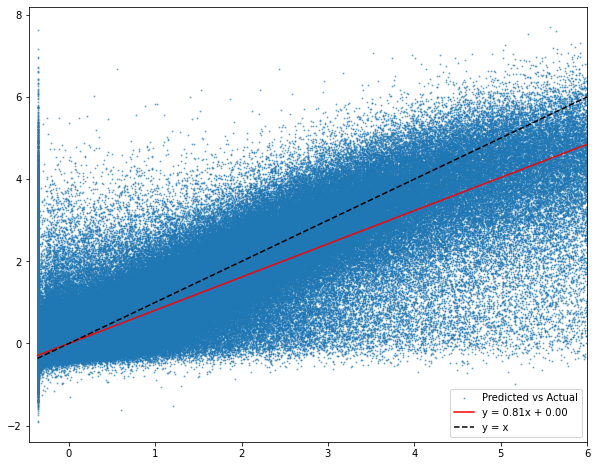

In [18]:
# plot histogram of predicted values
y_pred = regressor(torch.tensor(x_val).float()).detach().numpy()

plt.figure(figsize=(10,8))
plt.hist(y_val_reg, bins=100, density = True, histtype = 'step', label="Actual");
plt.hist(y_pred, bins=100, density=True, histtype='step', label='predicted');
plt.legend();
plt.xlim(-1,6)

# plot scatter plot of predicted vs actual
plt.figure(figsize = (10,8))
plt.scatter(y_val_reg, y_pred, s=1, alpha=0.5, label = "Predicted vs Actual");

min_x = np.min(y_val_reg)

# get line of best fit
m, b = np.polyfit(y_val_reg.squeeze(), y_pred, 1)
plt.plot(np.linspace(min_x,6,100), m*np.linspace(min_x,6,100)+b, 'r-', label=f'y = {m[0]:.2f}x + {b[0]:.2f}');

plt.plot([min_x,6],[min_x,6], 'k--', label = 'y = x');
plt.xlim(min_x - 0.1,6)
plt.legend();



#### Active Learning

First pass, will put everything into nice functions after

In [19]:
# Start with only a small subset of the data
indices = np.random.choice(len(x_train), size=10_000, replace=False)

training_reg = ITGDataset(x_train[indices], y_train_class[indices], y_train_reg[indices])
train_dataloader_reg = DataLoader(training_reg, batch_size=10_000, shuffle=True)

In [20]:
classifier.eval()

for X, y, z in train_dataloader_reg:
    pred = classifier(X.float())
    pred_class = torch.round(pred.squeeze()).detach().numpy()
    pred_class = pred_class.astype(int)
    # add data that returns one to a new dataset
    training_reg_pass = ITGDataset(X[pred_class == 1], y[pred_class == 1], z[pred_class == 1])

print(f"Number of points passing classifier: {len(training_reg_pass)}")
training_reg_pass_dataloader = DataLoader(training_reg_pass, shuffle=True)

Number of points passing classifier: 2528


In [21]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for m in model.modules():
        if m.__class__.__name__.startswith("Dropout"):
            m.train()

  0%|          | 0/100 [00:00<?, ?it/s]

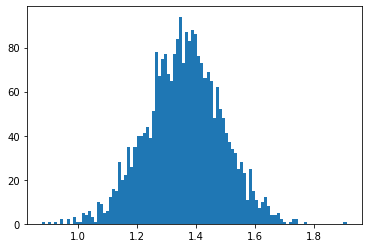

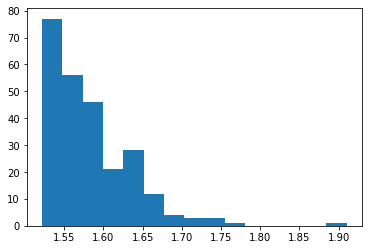

In [22]:
regressor.eval()
enable_dropout(regressor)

# evaluate model on training data 100 times and return points with largest uncertainty
runs = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(training_reg_pass_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs.append(flattened_predictions)

out_std = np.std(np.array(runs), axis=0)

plt.figure()
plt.hist(out_std, bins=100)

# get indices of top 10% of points
top_indices = np.argsort(out_std)[-int(len(out_std) * 0.1):]
plt.figure()
plt.hist(out_std[top_indices], bins=15);


### Maybe train using some of the original training dataset and high variance points for balance? 

In [23]:
regressor.train()
optimizer = torch.optim.Adam(regressor.parameters(), lr = 0.5 * learning_rate, weight_decay=1e-4)

x_top = x_train[top_indices]
y_class_top = y_train_reg[top_indices]
y_reg_top = y_train_reg[top_indices]

print(f"Validation MSE loss before fine tuning using high variance points:")
regression_test_loop(reg_val_dataloader, regressor, MSE_loss)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Add in some of the training data to balance the fine tuning on the most uncertain points
    train_idx = np.random.choice(len(x_train), size=len(top_indices), replace=False)
    x_tune = np.append(x_top, x_train[train_idx], axis=0)
    y_class_tune = np.append(y_class_top, y_train_class[train_idx].reshape(-1,1), axis=0)
    y_reg_tune = np.append(y_reg_top, y_train_reg[train_idx].reshape(-1,1), axis=0)

    reg_dataset = ITGDataset(x_tune, y_class_tune, y_reg_tune)
    reg_dataloader = DataLoader(reg_dataset, shuffle=True)

    regression_train_loop(reg_dataloader, regressor, MSE_loss, optimizer)
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")


Validation MSE loss before fine tuning using high variance points:
Test Error - avg loss: 0.198861 

Epoch 1
-------------------------------
loss: 0.005153
Test Error - avg loss: 0.219459 

Epoch 2
-------------------------------
loss: 0.014067
Test Error - avg loss: 0.206176 

Epoch 3
-------------------------------
loss: 0.000241
Test Error - avg loss: 0.235232 

Epoch 4
-------------------------------
loss: 0.000357
Test Error - avg loss: 0.216318 

Epoch 5
-------------------------------
loss: 0.002383
Test Error - avg loss: 0.223273 

Epoch 6
-------------------------------
loss: 0.008205
Test Error - avg loss: 0.220563 

Epoch 7
-------------------------------
loss: 0.001677
Test Error - avg loss: 0.223765 

Epoch 8
-------------------------------
loss: 0.000762
Test Error - avg loss: 0.232493 

Epoch 9
-------------------------------
loss: 0.000067
Test Error - avg loss: 0.232517 

Epoch 10
-------------------------------
loss: 0.001616
Test Error - avg loss: 0.223409 

Done!


In [24]:
# Recalculate uncertainty to see if it has reduced
reg_dataset_after = ITGDataset(x_top, y_class_top, y_reg_top)
reg_dataloader_after = DataLoader(reg_dataset_after, shuffle=True)
runs_after = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(reg_dataloader_after):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs_after.append(flattened_predictions)

out_std_after = np.std(np.array(runs_after), axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.5, 1.75)

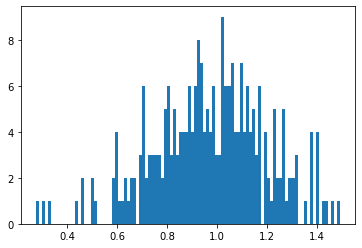

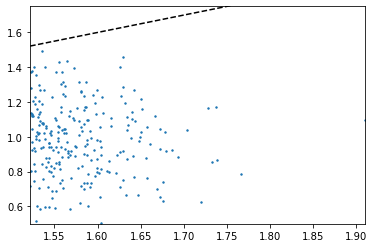

In [25]:
plt.figure()
plt.hist(out_std_after, bins=100);

plt.figure()
plt.scatter(out_std[top_indices], out_std_after, s=2, alpha=1);

plt.plot([0.0,2],[0,2], 'k--', label = 'y = x');
plt.xlim(out_std[top_indices].min(), out_std[top_indices].max())
plt.ylim(0.5,1.75)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.8786311149597168, 1.9099993705749512)

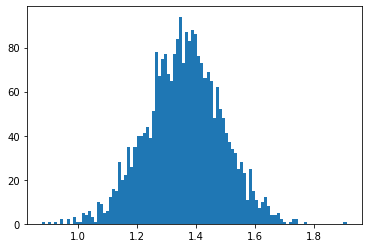

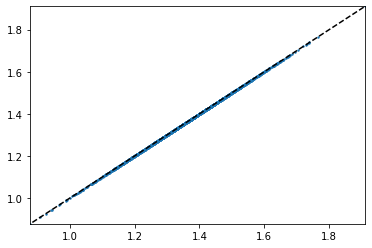

In [26]:
# Repeat uncertainty calculation on full dataset to see if it has increased

runs_full = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(training_reg_pass_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs_full.append(flattened_predictions)

out_std_full = np.std(np.array(runs), axis=0)

plt.figure()
plt.hist(out_std_full, bins=100)

plt.figure()
plt.scatter(out_std, out_std_full, s=2, alpha=1);
plt.plot([0.0,2],[0,2], 'k--', label = 'y = x');
plt.xlim(out_std.min(), out_std.max())
plt.ylim(out_std_full.min(), out_std_full.max())

### Now Turn into a Pipeline with Functions

In [ ]:
def select_random_points(X, y, z, n_points):
    """
    Selects n_points random points from the dataset.
    """
    indices = np.random.choice(len(X), n_points, replace=False)

    dataset = ITGDataset(X[indices], y[indices], z[indices])
    dataloader = DataLoader(training_reg, batch_size=n_points, shuffle=True)

    return dataset, dataloader

def unstable_itg_points(dataloader, classifier):
    """
    Returns a dataset of points that are unstable.
    """
    classifier.eval()
    unstable_points = []
    for step, (x, y, z) in enumerate(dataloader):
        pred = classifier(x.float())
        pred_class = torch.round(pred.squeeze()).detach().numpy()
        pred_class = pred_class.astype(int)
        # add data that returns one to a new dataset
        unstable_points.append(pred_class == 1)

        if step == 0:
            unstable_dataset = ITGDataset(x[pred_class == 1], y[pred_class == 1], z[pred_class == 1])
        else:
            unstable_dataset.add(x[pred_class == 1], y[pred_class == 1], z[pred_class == 1])
    

    print(f"Number of unstable points: {len(unstable_dataset)}")
    unstable_dataloader = DataLoader(unstable_dataset, shuffle=True)
    return unstable_dataloader

dataset, dataloader = select_random_points(x_train, y_train_class, y_train_reg, n_points=10_000)
zz = unstable_itg_points(dataloader, classifier)

for X, y, z in dataloader:
    pred = classifier(X.float())
    pred_class = torch.round(pred.squeeze()).detach().numpy()
    pred_class = pred_class.astype(int)
    # add data that returns one to a new dataset
    dataloader_pass = ITGDataset(X[pred_class == 1], y[pred_class == 1], z[pred_class == 1])

print(f"Number of points passing classifier: {len(dataloader_pass)}")

# check two arrays are the same (even if not in the same order)
assert np.array_equal(np.sort(torch.flatten(zz.dataset.X)), np.sort(torch.flatten(dataloader_pass.X)))

In [ ]:
def regressor_uncertainty(dataloader, regressor, keep = 0.1):
    """
    Calculates the uncertainty of the regressor on the points in the dataloader.
    Returns the most uncertain points.

    """

    regressor.eval()
    enable_dropout(regressor)

    # evaluate model on training data 100 times and return points with largest uncertainty
    runs = []
    for i in tqdm(range(100)):
        step_list = []
        for step, (x, y, z) in enumerate(dataloader):

            predictions = regressor(x.float()).detach().numpy()
            step_list.append(predictions)

        flattened_predictions = np.array(step_list).flatten()
        runs.append(flattened_predictions)

    out_std = np.std(np.array(runs), axis=0)

    top_indices = np.argsort(out_std)[-int(len(out_std) * keep):]

    uncertain_dataset = ITGDataset(
        dataloader.dataset.X[top_indices],
        dataloader.dataset.y[top_indices], 
        dataloader.dataset.z[top_indices]
        )

    uncertain_dataloader = DataLoader(uncertain_dataset, shuffle=True)

    return uncertain_dataloader